In [1]:
from post_processing import Analysis
import util

In [2]:
analysis = Analysis("diags202403152211")

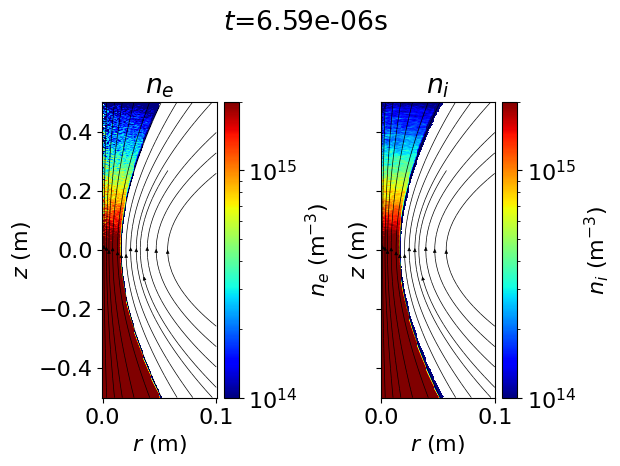

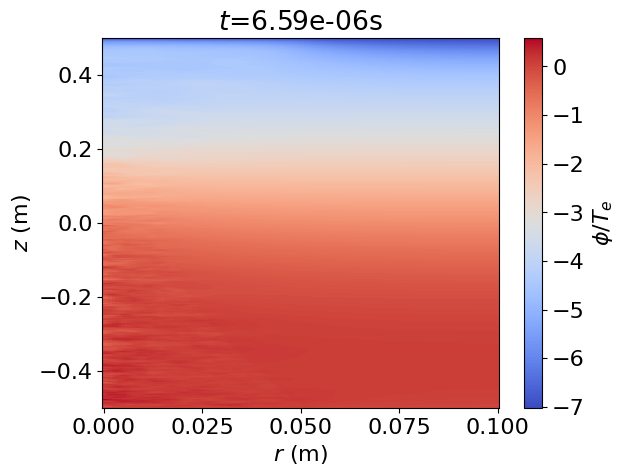

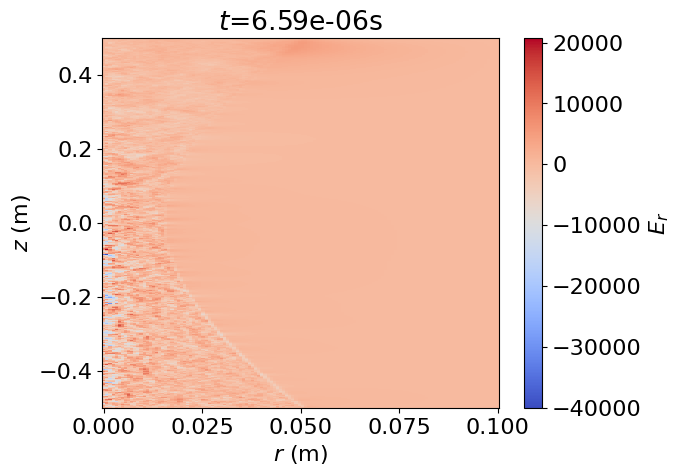

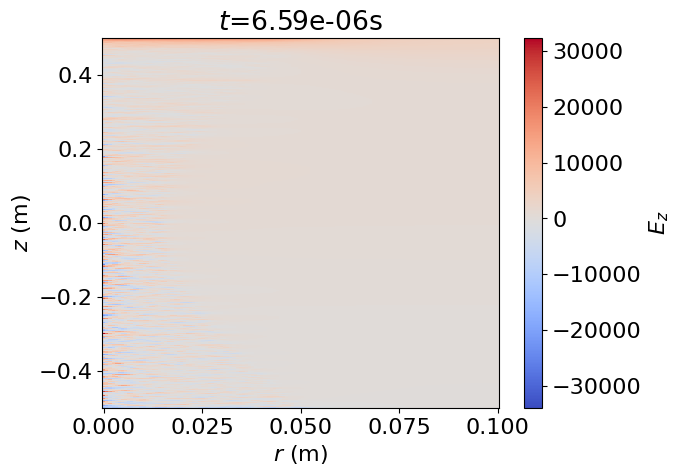

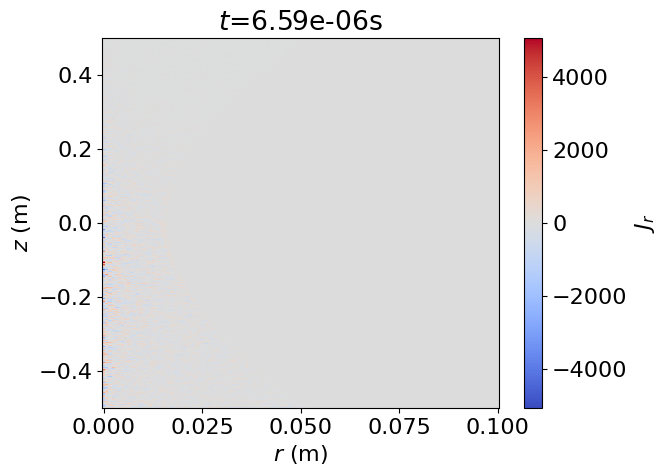

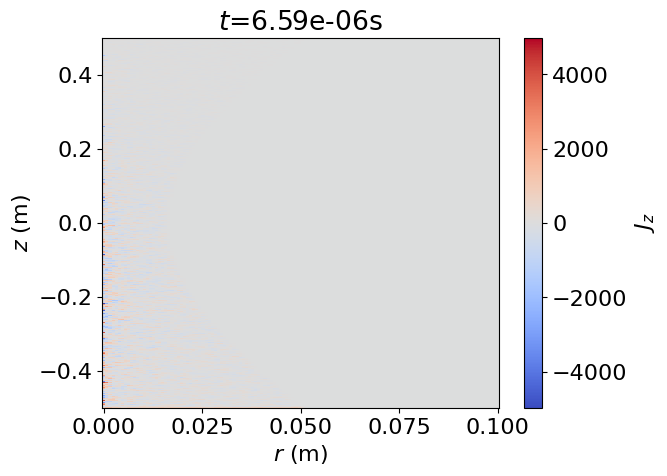

Total particles: 32737742.0


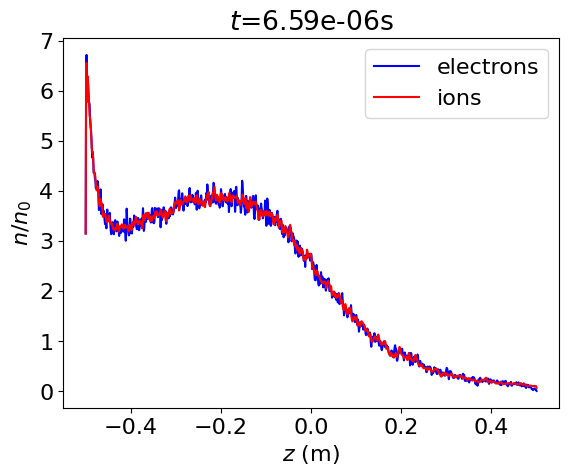

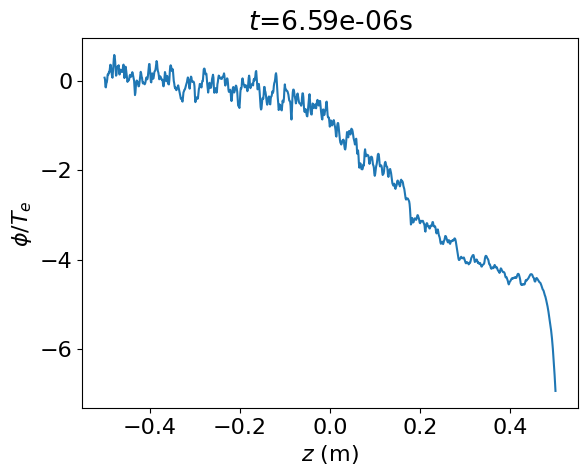

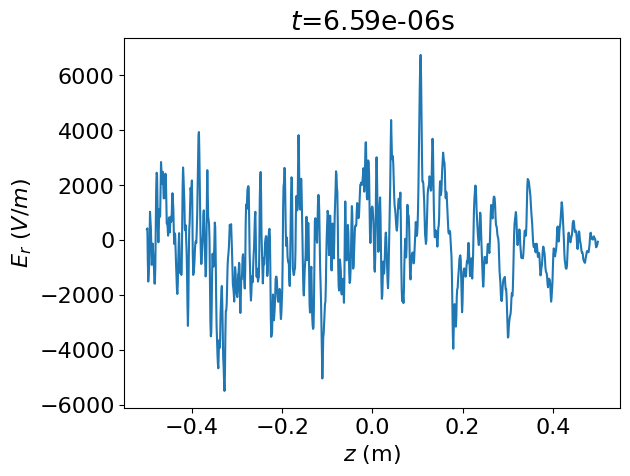

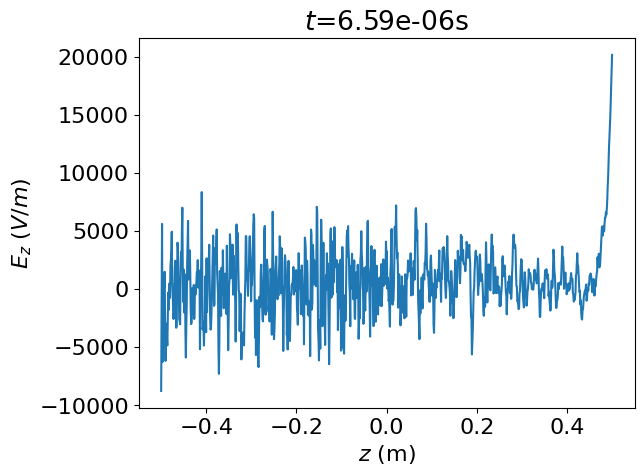

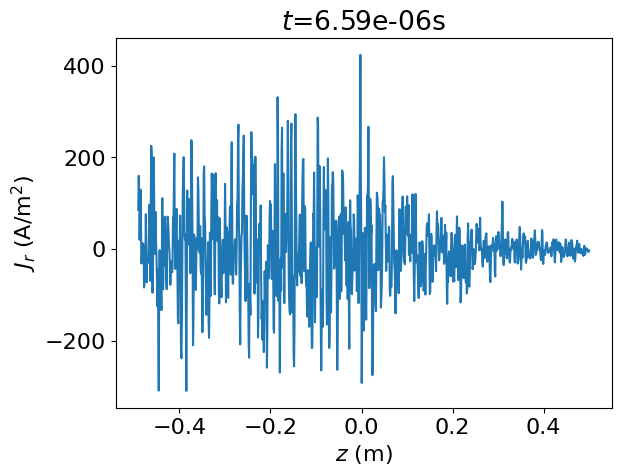

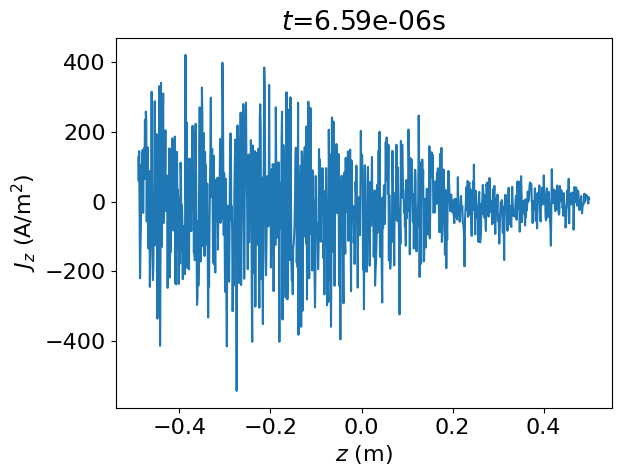

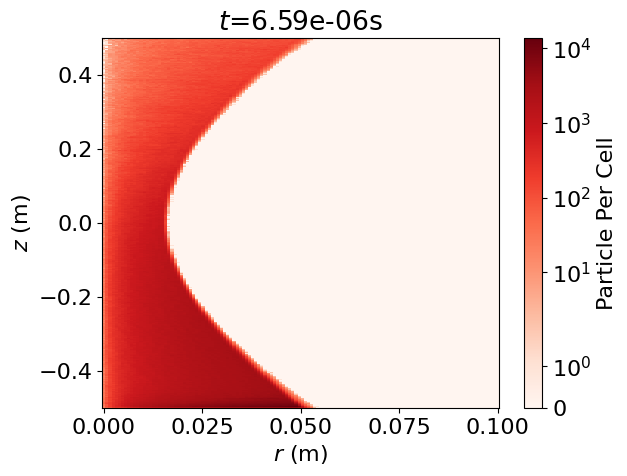

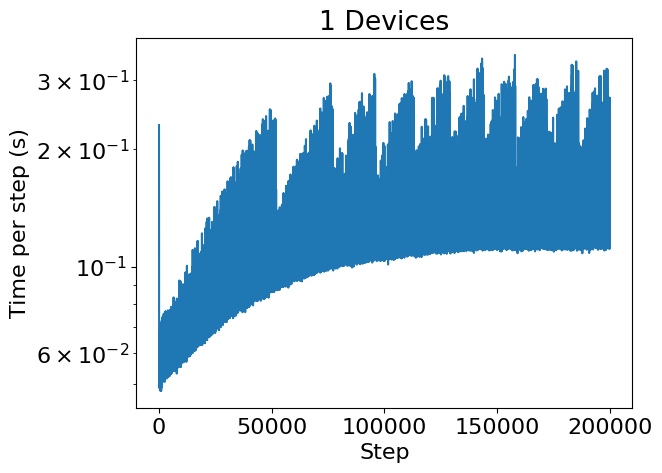

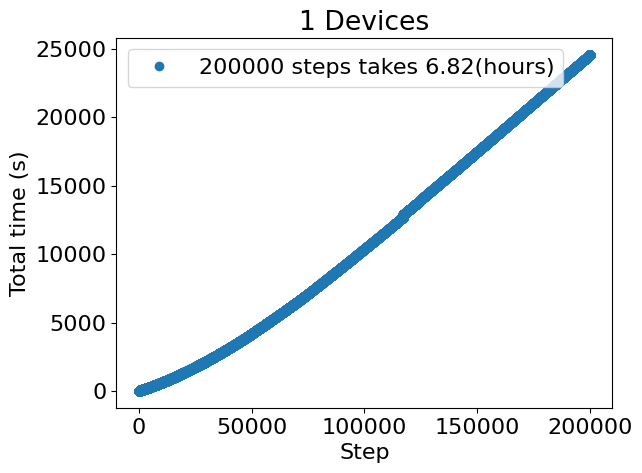

In [4]:
frame = -1
for plot_type in ["slice", "line"]:
    analysis.plot_density(frame, plot_type=plot_type)
    analysis.plot_potential(frame, plot_type=plot_type)
    analysis.plot_electric_field(frame, direction="r", plot_type=plot_type)
    analysis.plot_electric_field(frame, direction="z", plot_type=plot_type)
    analysis.plot_current_density(frame, direction="r", plot_type=plot_type)
    analysis.plot_current_density(frame, direction="z", plot_type=plot_type)
analysis.plot_part_per_cell(frame)
analysis.plot_time()

100%|██████████| 1541960/1541960 [00:02<00:00, 654906.08it/s]
/lustre07/scratch/huntfeng/magnetic-nozzle-warpx/post_processing.py:141: RuntimeWarning: invalid value encountered in divide
  return data / part_per_cell
100%|██████████| 30939943/30939943 [00:46<00:00, 668770.22it/s]


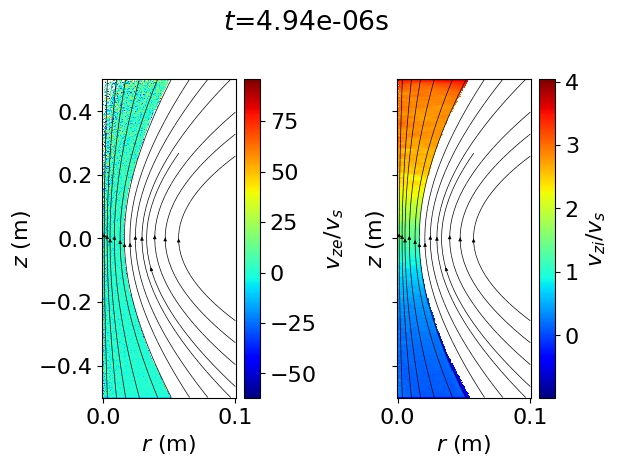

In [3]:
frame = -1
analysis.plot_velocity(frame, plot_type="slice")
# for plot_type in ["slice", "line"]:
    # analysis.plot_density(frame, plot_type=plot_type)
    # analysis.plot_potential(frame, plot_type=plot_type)
    # analysis.plot_current_density(frame, direction="z", plot_type=plot_type)
# analysis.plot_part_per_cell(frame)
# analysis.plot_time(total_step=100000)

100%|██████████| 1541960/1541960 [00:02<00:00, 671295.31it/s]
/lustre07/scratch/huntfeng/magnetic-nozzle-warpx/post_processing.py:141: RuntimeWarning: invalid value encountered in divide
  return data / part_per_cell
100%|██████████| 30939943/30939943 [00:46<00:00, 668244.19it/s]


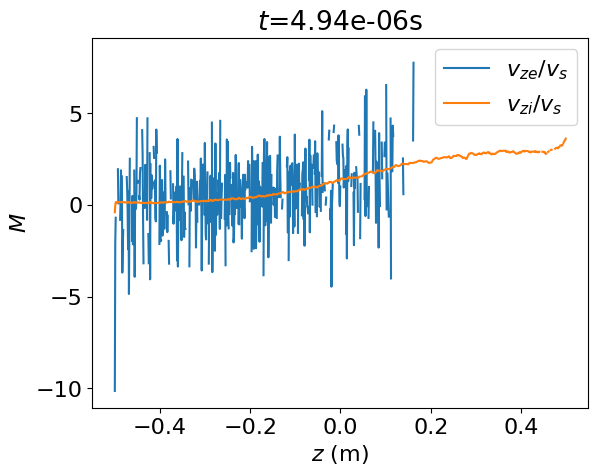

In [4]:
analysis.plot_velocity(frame, plot_type="line")